# ResNet101 Image Classifier

**This notebook should run correctly both in colab and on jupyter.**
- Uses stratified sampling (making sure all classes have same ratio in all sets).
- Uses metadata from **'data/encoded_final_data'**.
- Uses images from folder **'directly_processed_images'**.

## **Setup**

In [1]:
# use ice cream to conveniently print stuff
!pip install icecream

In [2]:
import sys
on_colab = 'google.colab' in sys.modules
if on_colab:
  print("Running notebook on google colab")
else:
  print("Notebook not running on google colab")

Running notebook on google colab


In [3]:
# imports
from icecream import ic
import pandas as pd
import numpy as np
import torch
import time
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import models, datasets, transforms
import timeit
import torchvision
# import torchsummary
from torchvision import transforms, datasets
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
# from torchsummary import summary
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns

# to save session
import pickle

from tqdm import tqdm

In [4]:
if on_colab:
  from google.colab import drive
  drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
print("PyTorch version:")
print(torch.__version__)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using {} device".format(device))

PyTorch version:
2.2.1+cu121
Using cuda device


## Define paths to image folder & metadata

In [6]:
# paths
if on_colab:
  metadata_path = '/content/drive/MyDrive/CDS Project/data/encoded_final_data.csv'
  images_path = '/content/drive/MyDrive/CDS Project/directly_processed_images'
else:
  metadata_path = '../data/encoded_final_data.csv'
  images_path = '../directly_processed_images'

In [7]:
metadata_df = pd.read_csv(metadata_path)
metadata_df

,image_id,age,head/neck,lower extremity,oral/genital,palms/soles,torso,upper extremity,female,male,target
0,ISIC_5136612,65.0,0,0,0,0,1,0,0,1,0
1,ISIC_0031002,65.0,0,0,0,0,0,1,0,1,0
2,ISIC_0026875,35.0,0,0,0,0,0,1,1,0,1
3,ISIC_0024371,70.0,0,1,0,0,0,0,0,1,2
4,ISIC_0027263,85.0,0,0,0,0,1,0,0,1,3
...,...,...,...,...,...,...,...,...,...,...,...
1395,ISIC_0027531,65.0,0,1,0,0,0,0,0,1,5
1396,ISIC_0025691,50.0,0,0,0,0,1,0,1,0,5
1397,ISIC_0028381,55.0,1,0,0,0,0,0,1,0,6
1398,ISIC_0033254,15.0,0,0,0,0,1,0,0,1,4


In [8]:
num_images = len([file for file in os.listdir(images_path) if os.path.isfile(os.path.join(images_path, file))])
print("Number of images: ", num_images)

Number of images:  1400


## Train test split (Stratified Sampling)

In [9]:
# Split data in features and target:
X = metadata_df  # features
y = metadata_df['target']  # target

# Splitting into train, test, and validation sets with stratified sampling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=0, stratify=y_temp)

ic(len(X_train), len(X_test), len(X_val))

ic| len(X_train): 1120, len(X_test): 140, len(X_val): 140


(1120, 140, 140)

In [10]:
# Resizing to 224x224, some transformations/augmentation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.RandomCrop(224, padding=4),
    # transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2), # random adjustments
    # transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),  # for blurry images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # standard normalization
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

## Define CustomDataset function

In [11]:
class CustomDataset(Dataset):
    def __init__(self, metadata, transform=None):
        self.metadata = metadata
        self.images_path = images_path
        self.transform = transform

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        img_id = self.metadata.iloc[idx, 0]  # Get image ID of sample using the metadata index
        img_name = os.path.join(self.images_path, f'processed_{img_id}.jpg')  # name of image files
        if not os.path.exists(img_name):
            raise FileNotFoundError(f"Image file not found: {img_name}")

        image = Image.open(img_name)
        row = metadata_df[metadata_df['image_id'] == img_id]
        label = row.iloc[0]['target']

        if self.transform is not None:
            image = self.transform(image)

        # # extract demographic features
        # age = torch.tensor(self.metadata.iloc[idx, 1])
        # localization = torch.tensor(self.metadata.iloc[idx, 3])
        # gender = torch.tensor(self.metadata.iloc[idx, 4])

        return image, label

## Define train, validation and test datasets/dataloaders

In [31]:
# custom datasets
train_dataset = CustomDataset(metadata=X_train, transform=train_transform)
val_dataset = CustomDataset(metadata=X_val, transform=val_transform)
test_dataset = CustomDataset(metadata=X_test, transform=val_transform)

# Create data loaders (optimized for faster loading)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# check
ic(len(train_dataset), len(val_dataset), len(test_dataset))

ic| len(train_dataset): 1120
    len(val_dataset): 140
    len(test_dataset): 140


(1120, 140, 140)

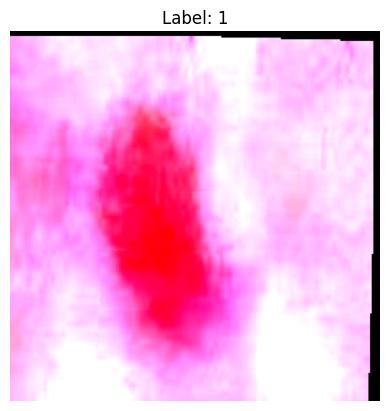

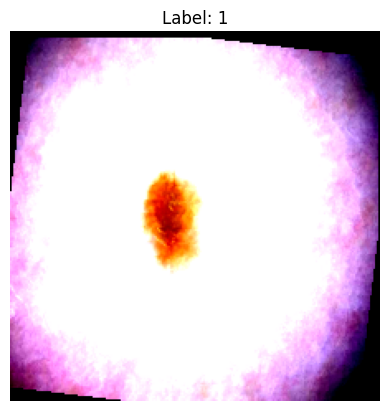

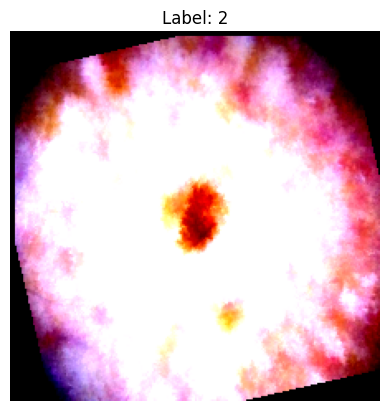

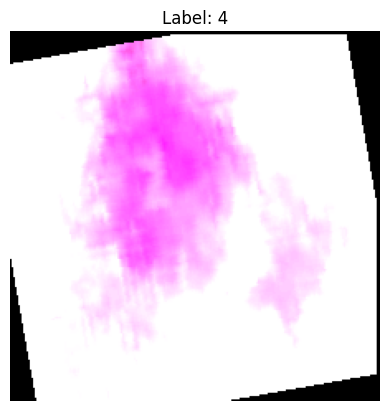

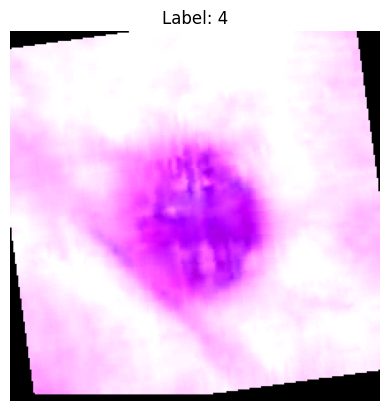

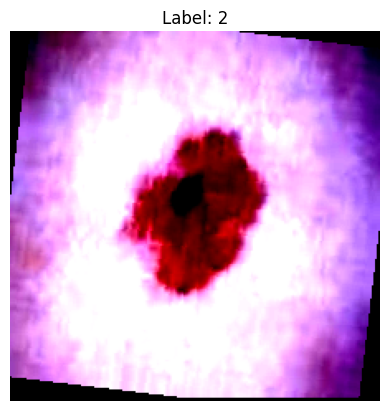

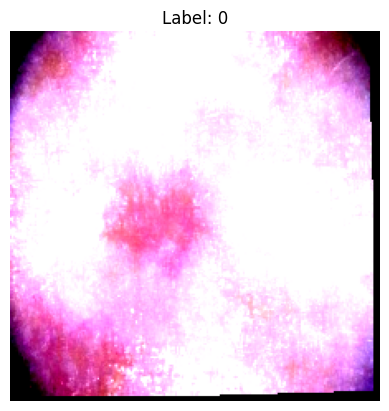

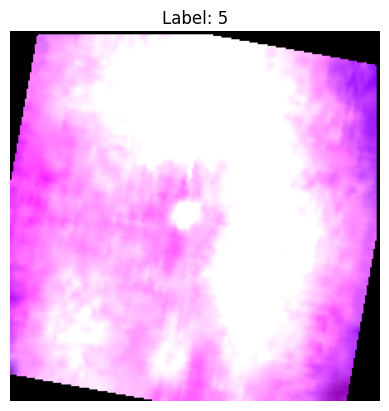

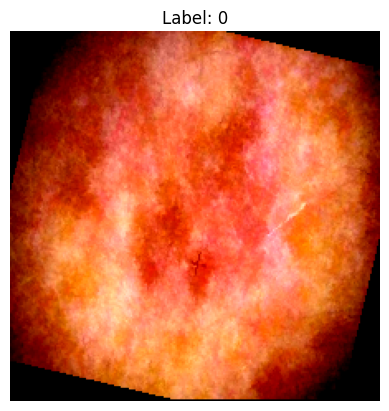

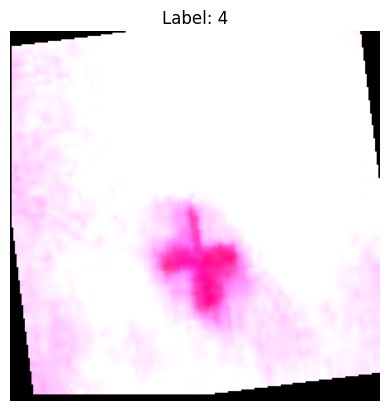

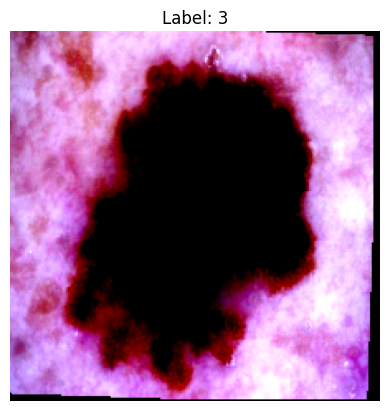

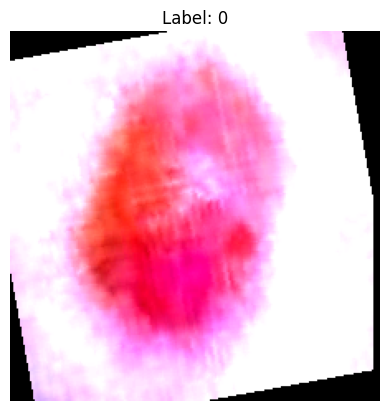

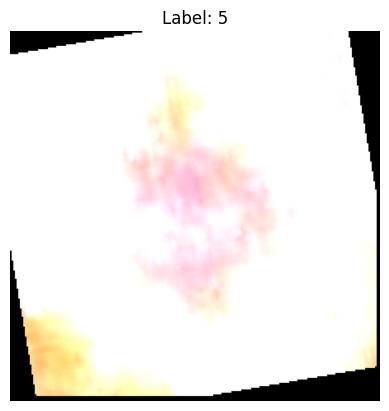

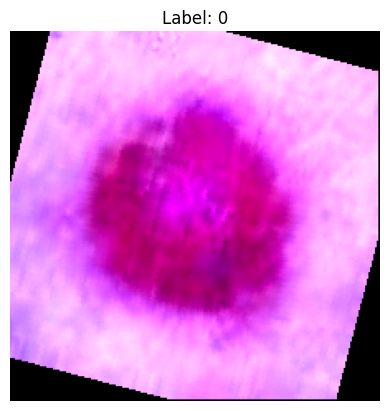

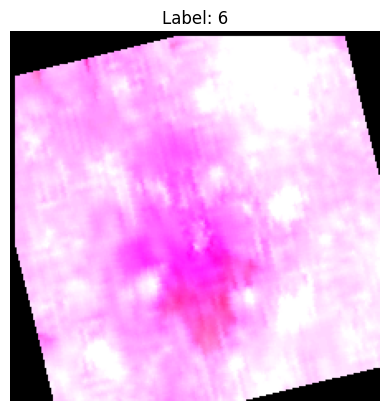

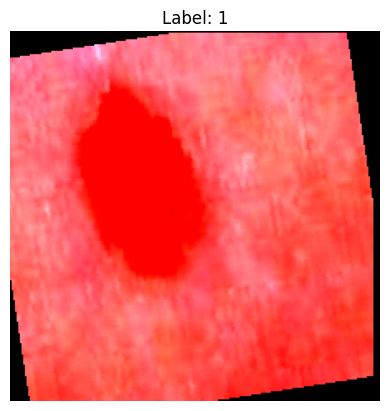

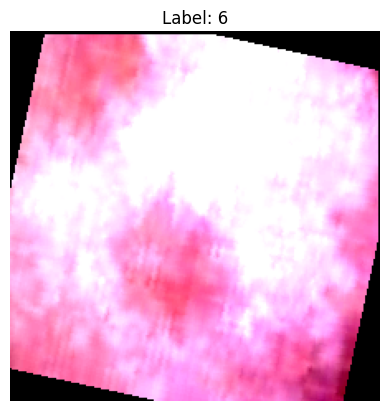

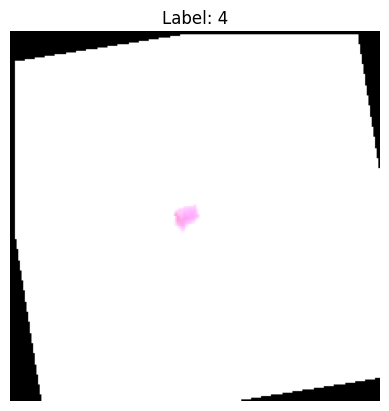

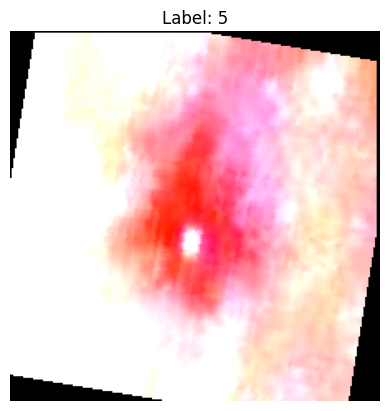

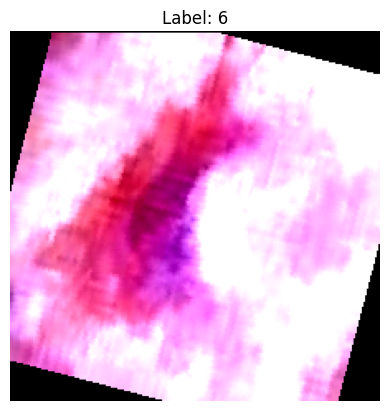

In [13]:
# test to check some samples in split sets
for index in range(20):

  image, label = train_dataset[index]

  # Display information about the sample
  # print("Random Sample Index:", index)
  # print("Image Shape:", image.shape)
  # print("Label:", label)
  # print(type(label))

  # Display the image
  plt.imshow(image.permute(1, 2, 0))  # permute to rearrange dimensions from CxHxW to HxWxC
  plt.title(f"Label: {label}")
  plt.axis('off')
  plt.show()

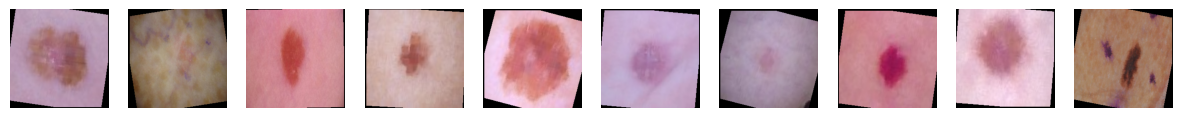

In [ ]:
# Get a single batch of data from the train_loader
# check if transformations are applied
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Convert the images tensor to numpy format for plotting
images = images.numpy()

# Plot some random images from the batch
num_images_to_show = 10  # Number of images you want to display

# Set up the figure
fig, axes = plt.subplots(1, num_images_to_show, figsize=(15, 3))

for i in range(num_images_to_show):
    # Convert image to the range [0, 1] and transpose to HWC format
    img = np.transpose(images[i], (1, 2, 0))
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img = np.clip(img, 0, 1)

    # Plot the image
    axes[i].imshow(img)
    axes[i].axis('off')
    # axes[i].set_title(f'Label: {labels[i]}')

# Show the figure
plt.show()

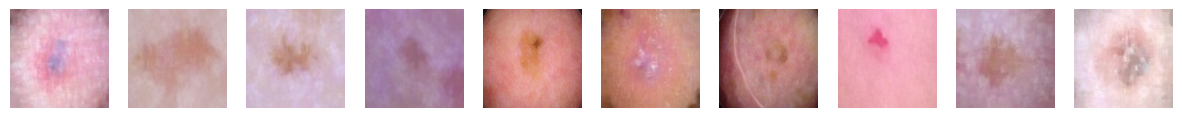

In [ ]:
# Get a single batch of data from the test_loader
data_iter = iter(val_loader)
images, labels = next(data_iter)

# Convert the images tensor to numpy format for plotting
images = images.numpy()

# Plot some random images from the batch
num_images_to_show = 10  # Number of images you want to display

# Set up the figure
fig, axes = plt.subplots(1, num_images_to_show, figsize=(15, 3))

for i in range(num_images_to_show):
    # Convert image to the range [0, 1] and transpose to HWC format
    img = np.transpose(images[i], (1, 2, 0))
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img = np.clip(img, 0, 1)

    # Plot the image
    axes[i].imshow(img)
    axes[i].axis('off')
    # axes[i].set_title(f'Label: {labels[i]}')

# Show the figure
plt.show()

## ResNet101 + modified last layer

In [20]:
model_resnet = models.resnet101(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:01<00:00, 97.3MB/s]


#### Modify last layer
- adjust to the appropriate number of output classes (7)

In [21]:
num_features = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_features, 7)

#### Adam optimizer + CEL

In [22]:
# Loss function: CEL
criterion = nn.CrossEntropyLoss()

# Optimizer: Adam
optimizer = torch.optim.Adam(model_resnet.parameters(), lr=0.001)
criterion.to(device)
model_resnet.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Training

In [17]:
# Training for one epoch

def train_model(model, criterion, optimizer, train_loader, val_loader):

    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in tqdm(train_loader):
        labels = labels.long()
        labels = labels.to(device)
        images = images.to(device)
        optimizer.zero_grad()
        # forward propagation, i.e. get predictions
        outputs = model(images)
        # calculate loss and backpropagate to model paramters:
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_acc = correct_train / total_train

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            labels=labels.long()
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_acc = correct_val / total_val

    return train_loss, val_loss, train_acc, val_acc

In [32]:
# specify epochs to train
total_epochs = 30

tl = []
vl = []
ta = []
va = []

for epoch in range(total_epochs):
    start_time = time.time()  # Record start time

    train_loss, val_loss, train_acc, val_acc = train_model(model_resnet, criterion, optimizer, train_loader, val_loader)
    tl.append(train_loss)
    vl.append(val_loss)
    ta.append(train_acc)
    va.append(val_acc)

    elapsed_time = time.time() - start_time  # Calculate elapsed time

    print(f"Epoch {epoch+1}/{total_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Elapsed Time: {elapsed_time:.2f} seconds")

100%|██████████| 35/35 [00:26<00:00,  1.32it/s]


Epoch 1/30, Train Loss: 1.7785, Train Acc: 0.3241, Val Loss: 1.9150, Val Acc: 0.3143, Elapsed Time: 28.06 seconds


100%|██████████| 35/35 [00:25<00:00,  1.37it/s]


Epoch 2/30, Train Loss: 1.5157, Train Acc: 0.4214, Val Loss: 4.5459, Val Acc: 0.2929, Elapsed Time: 27.01 seconds


100%|██████████| 35/35 [00:26<00:00,  1.34it/s]


Epoch 3/30, Train Loss: 1.3695, Train Acc: 0.4777, Val Loss: 1.7410, Val Acc: 0.3643, Elapsed Time: 27.54 seconds


100%|██████████| 35/35 [00:25<00:00,  1.37it/s]


Epoch 4/30, Train Loss: 1.2118, Train Acc: 0.5312, Val Loss: 1.5297, Val Acc: 0.4357, Elapsed Time: 27.05 seconds


100%|██████████| 35/35 [00:25<00:00,  1.38it/s]


Epoch 5/30, Train Loss: 1.2590, Train Acc: 0.5232, Val Loss: 1.5044, Val Acc: 0.4214, Elapsed Time: 26.77 seconds


100%|██████████| 35/35 [00:25<00:00,  1.39it/s]


Epoch 6/30, Train Loss: 1.1812, Train Acc: 0.5554, Val Loss: 2.0088, Val Acc: 0.3786, Elapsed Time: 26.73 seconds


100%|██████████| 35/35 [00:25<00:00,  1.35it/s]


Epoch 7/30, Train Loss: 1.1478, Train Acc: 0.5759, Val Loss: 1.5494, Val Acc: 0.5143, Elapsed Time: 27.33 seconds


100%|██████████| 35/35 [00:25<00:00,  1.37it/s]


Epoch 8/30, Train Loss: 1.0314, Train Acc: 0.6214, Val Loss: 1.9109, Val Acc: 0.4143, Elapsed Time: 26.97 seconds


100%|██████████| 35/35 [00:25<00:00,  1.35it/s]


Epoch 9/30, Train Loss: 1.0322, Train Acc: 0.6196, Val Loss: 1.4536, Val Acc: 0.5286, Elapsed Time: 27.40 seconds


100%|██████████| 35/35 [00:25<00:00,  1.38it/s]


Epoch 10/30, Train Loss: 1.0400, Train Acc: 0.6196, Val Loss: 1.4127, Val Acc: 0.5357, Elapsed Time: 26.94 seconds


100%|██████████| 35/35 [00:25<00:00,  1.37it/s]


Epoch 11/30, Train Loss: 0.9434, Train Acc: 0.6357, Val Loss: 1.5737, Val Acc: 0.4571, Elapsed Time: 27.03 seconds


100%|██████████| 35/35 [00:25<00:00,  1.36it/s]


Epoch 12/30, Train Loss: 0.9326, Train Acc: 0.6643, Val Loss: 1.1761, Val Acc: 0.5929, Elapsed Time: 27.15 seconds


100%|██████████| 35/35 [00:25<00:00,  1.37it/s]


Epoch 13/30, Train Loss: 0.9741, Train Acc: 0.6420, Val Loss: 1.3655, Val Acc: 0.5857, Elapsed Time: 27.09 seconds


100%|██████████| 35/35 [00:25<00:00,  1.37it/s]


Epoch 14/30, Train Loss: 0.8783, Train Acc: 0.6839, Val Loss: 1.1724, Val Acc: 0.5786, Elapsed Time: 26.99 seconds


100%|██████████| 35/35 [00:25<00:00,  1.37it/s]


Epoch 15/30, Train Loss: 0.8584, Train Acc: 0.6777, Val Loss: 1.2954, Val Acc: 0.5429, Elapsed Time: 27.05 seconds


100%|██████████| 35/35 [00:25<00:00,  1.37it/s]


Epoch 16/30, Train Loss: 0.8627, Train Acc: 0.6830, Val Loss: 1.4499, Val Acc: 0.5071, Elapsed Time: 27.03 seconds


100%|██████████| 35/35 [00:25<00:00,  1.36it/s]


Epoch 17/30, Train Loss: 0.8481, Train Acc: 0.6929, Val Loss: 1.3792, Val Acc: 0.5643, Elapsed Time: 27.15 seconds


100%|██████████| 35/35 [00:25<00:00,  1.37it/s]


Epoch 18/30, Train Loss: 0.7275, Train Acc: 0.7357, Val Loss: 1.2139, Val Acc: 0.5857, Elapsed Time: 26.96 seconds


100%|██████████| 35/35 [00:26<00:00,  1.30it/s]


Epoch 19/30, Train Loss: 0.7815, Train Acc: 0.7027, Val Loss: 1.6058, Val Acc: 0.5357, Elapsed Time: 28.75 seconds


100%|██████████| 35/35 [00:25<00:00,  1.38it/s]


Epoch 20/30, Train Loss: 0.7602, Train Acc: 0.7241, Val Loss: 1.4559, Val Acc: 0.5643, Elapsed Time: 27.01 seconds


100%|██████████| 35/35 [00:25<00:00,  1.38it/s]


Epoch 21/30, Train Loss: 0.7671, Train Acc: 0.7143, Val Loss: 1.3794, Val Acc: 0.5786, Elapsed Time: 26.93 seconds


100%|██████████| 35/35 [00:25<00:00,  1.38it/s]


Epoch 22/30, Train Loss: 0.6918, Train Acc: 0.7527, Val Loss: 1.5921, Val Acc: 0.5071, Elapsed Time: 26.89 seconds


100%|██████████| 35/35 [00:25<00:00,  1.39it/s]


Epoch 23/30, Train Loss: 0.6907, Train Acc: 0.7473, Val Loss: 1.5020, Val Acc: 0.5571, Elapsed Time: 26.81 seconds


100%|██████████| 35/35 [00:25<00:00,  1.39it/s]


Epoch 24/30, Train Loss: 0.6319, Train Acc: 0.7580, Val Loss: 1.1984, Val Acc: 0.5429, Elapsed Time: 26.80 seconds


100%|██████████| 35/35 [00:25<00:00,  1.38it/s]


Epoch 25/30, Train Loss: 0.6665, Train Acc: 0.7616, Val Loss: 1.6936, Val Acc: 0.5429, Elapsed Time: 26.91 seconds


100%|██████████| 35/35 [00:25<00:00,  1.39it/s]


Epoch 26/30, Train Loss: 0.6797, Train Acc: 0.7536, Val Loss: 1.3261, Val Acc: 0.5929, Elapsed Time: 26.84 seconds


100%|██████████| 35/35 [00:25<00:00,  1.39it/s]


Epoch 27/30, Train Loss: 0.5512, Train Acc: 0.8071, Val Loss: 1.2728, Val Acc: 0.5643, Elapsed Time: 26.76 seconds


100%|██████████| 35/35 [00:25<00:00,  1.39it/s]


Epoch 28/30, Train Loss: 0.6038, Train Acc: 0.7812, Val Loss: 1.2813, Val Acc: 0.6000, Elapsed Time: 26.78 seconds


100%|██████████| 35/35 [00:25<00:00,  1.39it/s]


Epoch 29/30, Train Loss: 0.5875, Train Acc: 0.7946, Val Loss: 1.2480, Val Acc: 0.5929, Elapsed Time: 26.82 seconds


100%|██████████| 35/35 [00:25<00:00,  1.39it/s]


Epoch 30/30, Train Loss: 0.5208, Train Acc: 0.8143, Val Loss: 1.0759, Val Acc: 0.6500, Elapsed Time: 26.84 seconds


In [37]:
for epoch in range(10):
    start_time = time.time()  # Record start time

    train_loss, val_loss, train_acc, val_acc = train_model(model_resnet, criterion, optimizer, train_loader, val_loader)
    tl.append(train_loss)
    vl.append(val_loss)
    ta.append(train_acc)
    va.append(val_acc)

    elapsed_time = time.time() - start_time  # Calculate elapsed time

    print(f"Epoch {30+epoch+1}/{40}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Elapsed Time: {elapsed_time:.2f} seconds")

100%|██████████| 35/35 [00:26<00:00,  1.33it/s]


Epoch 31/40, Train Loss: 0.4979, Train Acc: 0.8143, Val Loss: 1.4829, Val Acc: 0.5929, Elapsed Time: 28.06 seconds


100%|██████████| 35/35 [00:25<00:00,  1.35it/s]


Epoch 32/40, Train Loss: 0.4991, Train Acc: 0.8089, Val Loss: 1.1123, Val Acc: 0.6000, Elapsed Time: 27.49 seconds


100%|██████████| 35/35 [00:26<00:00,  1.31it/s]


Epoch 33/40, Train Loss: 0.5101, Train Acc: 0.8045, Val Loss: 1.2143, Val Acc: 0.6357, Elapsed Time: 28.64 seconds


100%|██████████| 35/35 [00:25<00:00,  1.38it/s]


Epoch 34/40, Train Loss: 0.4833, Train Acc: 0.8259, Val Loss: 1.2497, Val Acc: 0.6143, Elapsed Time: 26.88 seconds


100%|██████████| 35/35 [00:25<00:00,  1.38it/s]


Epoch 35/40, Train Loss: 0.4088, Train Acc: 0.8580, Val Loss: 1.0527, Val Acc: 0.7214, Elapsed Time: 26.72 seconds


100%|██████████| 35/35 [00:25<00:00,  1.39it/s]


Epoch 36/40, Train Loss: 0.3743, Train Acc: 0.8705, Val Loss: 1.1713, Val Acc: 0.6143, Elapsed Time: 26.57 seconds


100%|██████████| 35/35 [00:25<00:00,  1.38it/s]


Epoch 37/40, Train Loss: 0.4110, Train Acc: 0.8411, Val Loss: 1.5742, Val Acc: 0.5786, Elapsed Time: 26.82 seconds


100%|██████████| 35/35 [00:25<00:00,  1.36it/s]


Epoch 38/40, Train Loss: 0.3996, Train Acc: 0.8536, Val Loss: 1.4944, Val Acc: 0.5929, Elapsed Time: 27.30 seconds


100%|██████████| 35/35 [00:26<00:00,  1.30it/s]


Epoch 39/40, Train Loss: 0.3902, Train Acc: 0.8455, Val Loss: 1.5941, Val Acc: 0.5286, Elapsed Time: 28.40 seconds


100%|██████████| 35/35 [00:25<00:00,  1.38it/s]


Epoch 40/40, Train Loss: 0.3899, Train Acc: 0.8536, Val Loss: 1.4205, Val Acc: 0.6214, Elapsed Time: 26.75 seconds


In [ ]:
for epoch in range(10):
    start_time = time.time()  # Record start time

    train_loss, val_loss, train_acc, val_acc = train_model(model_resnet, criterion, optimizer, train_loader, val_loader)
    tl.append(train_loss)
    vl.append(val_loss)
    ta.append(train_acc)
    va.append(val_acc)

    elapsed_time = time.time() - start_time  # Calculate elapsed time

    print(f"Epoch {40+epoch+1}/{50}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Elapsed Time: {elapsed_time:.2f} seconds")

### Visualisation

In [24]:
# visualisation function
def plotResults():
    plt.figure(figsize=(10,6))
    epovec=range(len(ta))
    plt.plot(epovec,ta,epovec,tl,epovec,va,epovec,vl,linewidth=3)
    plt.legend(('Training Accuracy','Training Loss','Validation Accuracy','Validation Loss'))

    # make the graph understandable:
    plt.title("Losses and Accuracies")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.show()

In [25]:
# plot loss function
def plotLosses():
    plt.figure(figsize=(10,6))
    epovec=range(len(tl))
    plt.plot(epovec,tl,epovec,vl,linewidth=3)
    plt.legend(('Training Loss', 'Validation Loss'))

    # make the graph understandable:
    plt.title("Training and Validation Losses")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.show()

In [26]:
# plot accuracies function
def plotAccuracies():
    plt.figure(figsize=(10,6))
    epovec=range(len(ta))
    plt.plot(epovec,ta,epovec,va,linewidth=3)
    plt.legend(('Training Accuracy', 'Validation Accuracy'))

    # make the graph understandable:
    plt.title("Training and Validation Accuracies")
    plt.xlabel("Epoch #")
    plt.ylabel("Accuracy")
    plt.show()

In [27]:
# evaluate model function
def evaluate_model(model, criterion, data_loader):
    model.eval()
    loss = 0.0
    correct = 0
    total = 0

    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            labels = labels.long()
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss += criterion(outputs, labels).item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    loss /= len(data_loader.dataset)
    accuracy = correct / total

    return loss, accuracy, all_predictions, all_labels

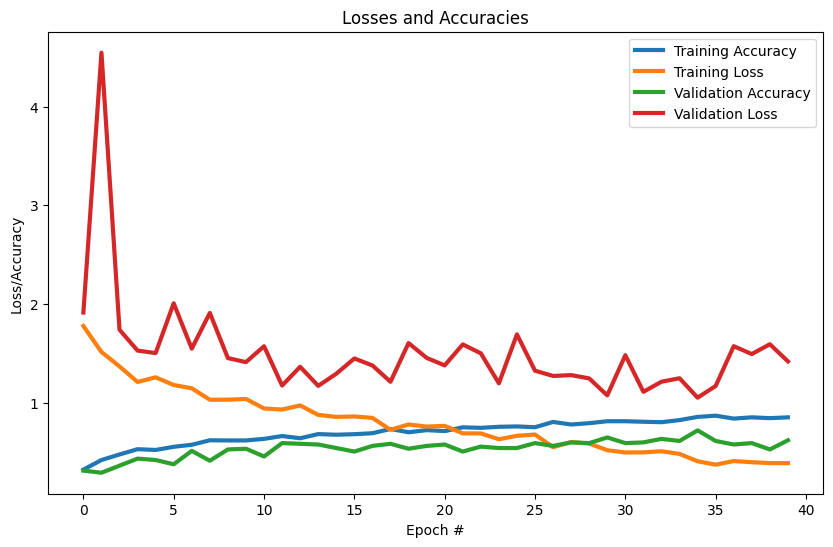

In [38]:
plotResults()

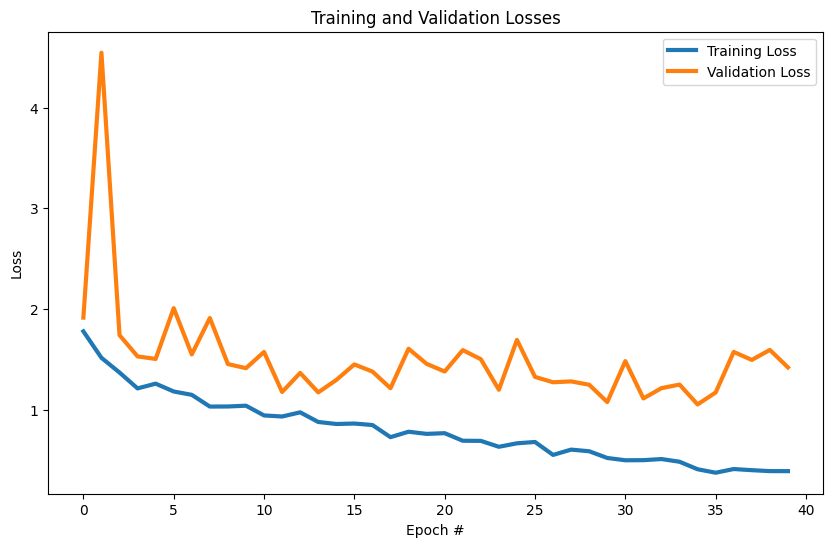

In [39]:
# plot losses separately
plotLosses()

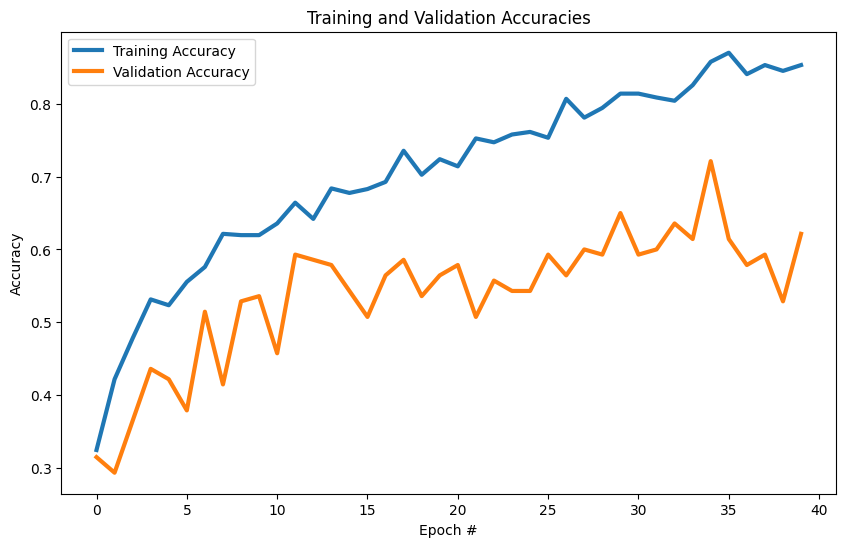

In [40]:
# plot accuracies separately
plotAccuracies()

### Evaluation on Test Set

In [42]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# Evaluate model
test_loss, test_accuracy, all_predictions, all_labels = evaluate_model(model_resnet, criterion, test_loader)

# Compute classification report
report = classification_report(all_labels, all_predictions)
print("Classification Report:\n", report)

# Compute confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
print("Confusion Matrix:\n", conf_matrix)

# Compute accuracy per class
class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
print("Accuracy per Class:", class_accuracy)
print("Test accuracy: ", test_accuracy)

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.70      0.76        20
           1       0.56      0.50      0.53        20
           2       0.55      0.60      0.57        20
           3       0.53      0.40      0.46        20
           4       0.82      0.90      0.86        20
           5       0.45      0.70      0.55        20
           6       0.60      0.45      0.51        20

    accuracy                           0.61       140
   macro avg       0.62      0.61      0.60       140
weighted avg       0.62      0.61      0.60       140

Confusion Matrix:
 [[14  1  0  0  1  4  0]
 [ 2 10  1  3  0  2  2]
 [ 0  3 12  3  0  1  1]
 [ 0  4  4  8  1  2  1]
 [ 0  0  1  1 18  0  0]
 [ 1  0  1  0  2 14  2]
 [ 0  0  3  0  0  8  9]]
Accuracy per Class: [0.7  0.5  0.6  0.4  0.9  0.7  0.45]
Test accuracy:  0.6071428571428571
